In [1]:
import ROOT as rt
import array as arr
import math

from strangehelper import get_parabola, make_mixed_corrections

Welcome to JupyROOT 6.24/06


In [2]:
# epsilon used to avoid bin edge nightmares (if you pick a value that lies on bin edge, it defaults to right bin)
EPSILON = 0.00001

In [3]:
# UE line method
USE_AVG = 1
USE_ZYAM = 0
USE_NONEG = 0
assert sum([USE_AVG, USE_ZYAM, USE_NONEG]) == 1, "Only select 1 method for UE line please"

In [4]:
DELTA_ETA_MAX = 1.4 - EPSILON

In [5]:
TRIG_PT_LOW = 4
TRIG_PT_HIGH = 8 - EPSILON
ASSOC_PT_LOW = 2 
ASSOC_PT_HIGH = 4 - EPSILON

In [6]:
SIG_MIN = 1.108 
SIG_MAX = 1.124 - EPSILON

In [7]:
c = rt.TCanvas("main_canvas", "Main Canvas", 55, 55, 800, 700)

In [8]:
input_file_0_20 = rt.TFile("../online/closure/AnalysisResults.root")
input_list_0_20 = input_file_0_20.Get("h-lambda")

In [9]:
trig_dist_0_20 = input_list_0_20.FindObject("fTriggerDistEff")
lambda_dist_0_20 = input_list_0_20.FindObject("fTriggeredLambdaDist")
trig_dist_0_20_mc = input_list_0_20.FindObject("fTriggerDist_MC")
lambda_dist_0_20_mc = input_list_0_20.FindObject("fLambdaDist_MC")

In [10]:
h_h_0_20 = input_list_0_20.FindObject("fDphiHHEff")
h_h_mixed_0_20 = input_list_0_20.FindObject("fDphiHHMixed")
h_h_0_20_mc = input_list_0_20.FindObject("fDphiHH_MC")
h_h_mixed_0_20_mc = input_list_0_20.FindObject("fDphiHHMixed_MC")

In [11]:
h_lambda_0_20 = input_list_0_20.FindObject("fDphiHLambdaEff")
h_lambda_mixed_0_20 = input_list_0_20.FindObject("fDphiHLambdaMixed")
h_lambda_0_20_mc = input_list_0_20.FindObject("fDphiHLambda_MC")
h_lambda_mixed_0_20_mc = input_list_0_20.FindObject("fDphiHLambdaMixed_MC")

In [12]:
# Setting the trigger Pt (this is never changed again)
trig_dist_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
trig_dist_0_20_mc.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_0_20_mc.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_0_20_mc.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_0_20_mc.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_0_20_mc.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)

In [13]:
# Setting the associated Pt (this is never changed again)
lambda_dist_0_20.GetAxis(0).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_mixed_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
lambda_dist_0_20_mc.GetAxis(0).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_0_20_mc.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_mixed_0_20_mc.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_0_20_mc.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_0_20_mc.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)

In [14]:
trig_pt_dist_0_20 = trig_dist_0_20.Projection(0).Clone("trig_pt_dist_0_20")
trig_phi_dist_0_20 = trig_dist_0_20.Projection(1).Clone("trig_phi_dist_0_20")
trig_eta_dist_0_20 = trig_dist_0_20.Projection(2).Clone("trig_eta_dist_0_20")
trig_2d_dist_0_20 = trig_dist_0_20.Projection(0, 3).Clone("trig_2d_dist_0_20")

trig_pt_dist_0_20.SetTitle("Trigger #font[12]{p}_{T} Distribution (red: reconstruced, blue: MC truth)")
trig_pt_dist_0_20.Sumw2()
trig_pt_dist_0_20.SetLineColor(rt.kRed)

trig_phi_dist_0_20.SetTitle("Trigger #varphi Distribution (red: reconstructed, blue: MC truth")
trig_phi_dist_0_20.Sumw2()
trig_phi_dist_0_20.SetLineColor(rt.kRed)

trig_eta_dist_0_20.SetTitle("Trigger #eta Distribution (red: reconstructed, blue: MC truth")
trig_eta_dist_0_20.Sumw2()
trig_eta_dist_0_20.SetLineColor(rt.kRed)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [15]:
trig_pt_dist_0_20_mc = trig_dist_0_20_mc.Projection(0).Clone("trig_pt_dist_0_20_mc")
trig_phi_dist_0_20_mc = trig_dist_0_20_mc.Projection(1).Clone("trig_phi_dist_0_20_mc")
trig_eta_dist_0_20_mc = trig_dist_0_20_mc.Projection(2).Clone("trig_eta_dist_0_20_mc")
trig_2d_dist_0_20_mc = trig_dist_0_20_mc.Projection(0, 3).Clone("trig_2d_dist_0_20_mc")

trig_pt_dist_0_20_mc.SetTitle("Trigger #font[12]{p}_{T} Distribution (red: reconstruced, blue: MC truth)")
trig_pt_dist_0_20_mc.Sumw2()
trig_pt_dist_0_20_mc.SetLineColor(rt.kBlue)

trig_phi_dist_0_20_mc.SetTitle("Trigger #varphi Distribution (red: reconstructed, blue: MC truth")
trig_phi_dist_0_20_mc.Sumw2()
trig_phi_dist_0_20_mc.SetLineColor(rt.kBlue)

trig_eta_dist_0_20_mc.SetTitle("Trigger #eta Distribution (red: reconstructed, blue: MC truth")
trig_eta_dist_0_20_mc.Sumw2()
trig_eta_dist_0_20_mc.SetLineColor(rt.kBlue)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [16]:
num_trigs_0_20 = trig_2d_dist_0_20.Integral()
num_trigs_0_20_mc = trig_2d_dist_0_20_mc.Integral()

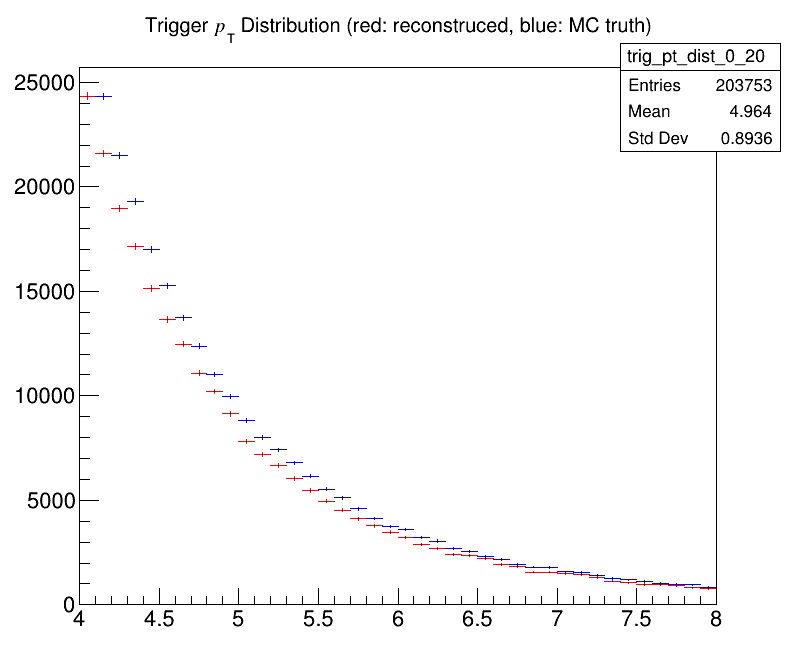

In [17]:
trig_pt_dist_0_20.Draw()
trig_pt_dist_0_20_mc.Draw("SAME")
c.Draw()

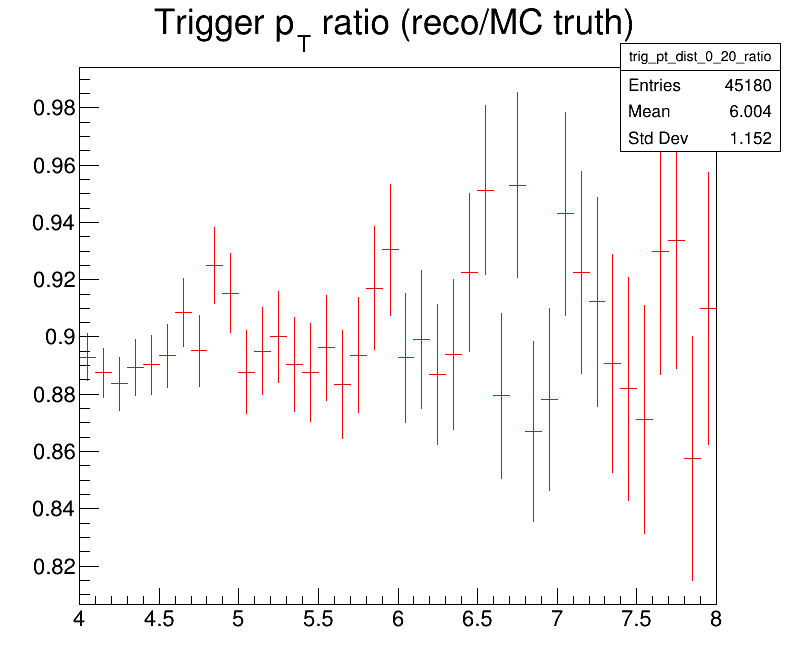

In [18]:
trig_pt_dist_0_20_ratio = trig_pt_dist_0_20.Clone("trig_pt_dist_0_20_ratio")
trig_pt_dist_0_20_ratio.Divide(trig_pt_dist_0_20_mc)
trig_pt_dist_0_20_ratio.SetTitle("Trigger p_{T} ratio (reco/MC truth)")
trig_pt_dist_0_20_ratio.Draw()
c.Draw()

In [19]:
trig_pt_dist_0_20.Scale(1/num_trigs_0_20)
trig_pt_dist_0_20_mc.Scale(1/num_trigs_0_20_mc)

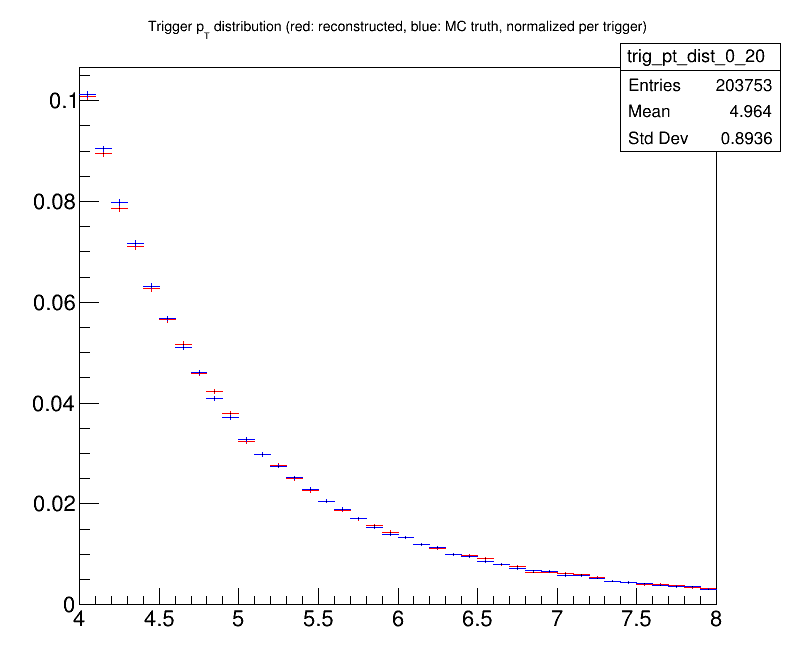

In [20]:
trig_pt_dist_0_20.SetTitle("Trigger p_{T} distribution (red: reconstructed, blue: MC truth, normalized per trigger)")
trig_pt_dist_0_20.Draw()
trig_pt_dist_0_20_mc.Draw("SAME")
c.Draw()

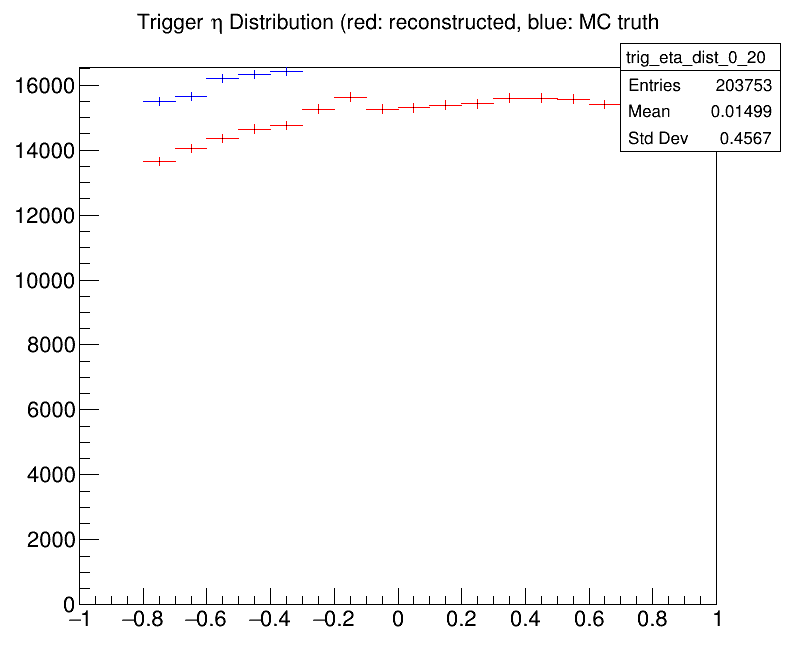

In [21]:
trig_eta_dist_0_20.Draw()
trig_eta_dist_0_20_mc.Draw("SAME")
c.Draw()

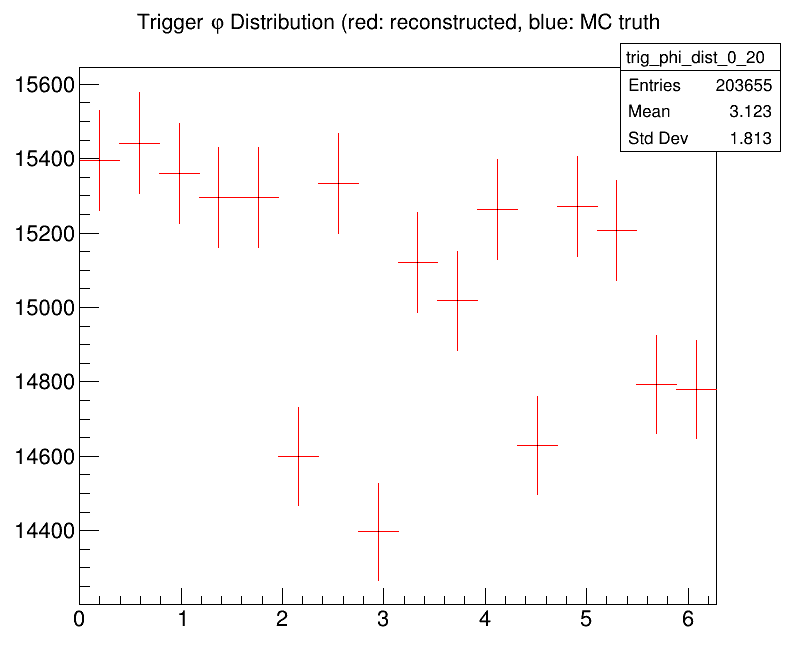

In [22]:
trig_phi_dist_0_20.Draw()
trig_phi_dist_0_20_mc.Draw("SAME")
c.Draw()

### Signal analysis section

In [23]:
# eta cuts first
lambda_dist_0_20.GetAxis(2).SetRangeUser(-0.8, 0.8)
lambda_mass_dist_0_20 = lambda_dist_0_20.Projection(3).Clone("lambda_mass_dist_0_20")

In [24]:
lambda_mass_dist_0_20.SetTitle("#Lambda^{0} invariant mass distribution (p-#pi)")
lambda_mass_dist_0_20.Sumw2()
lambda_mass_dist_0_20.SetLineWidth(2)
lambda_mass_dist_0_20.GetXaxis().SetTitle("Mass (GeV/c^{2})")
lambda_mass_dist_0_20.GetYaxis().SetTitle("#frac{dN_{p-#pi}}{dM}")

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


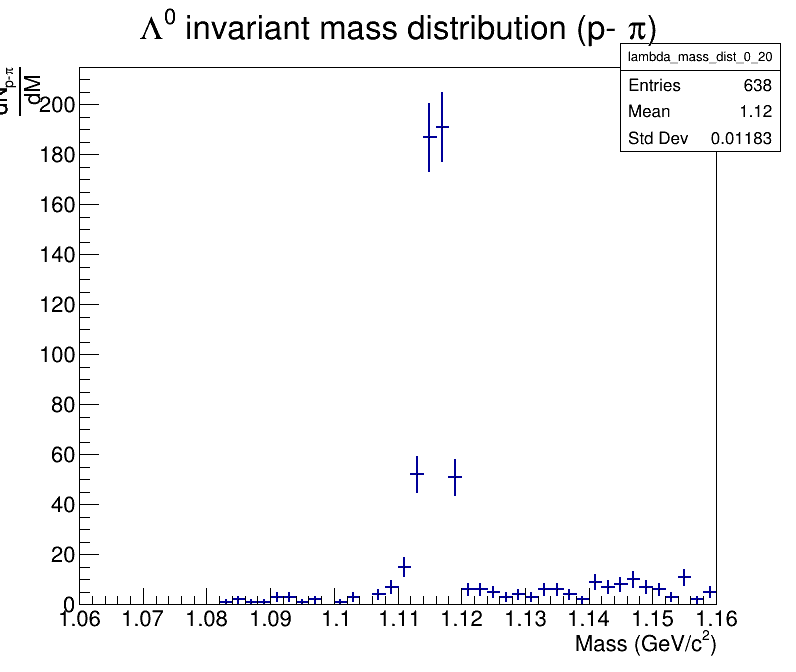

In [25]:
lambda_mass_dist_0_20.Rebin(2)
lambda_mass_dist_0_20.Draw()
c.Draw()

In [26]:
bin_1 = lambda_mass_dist_0_20.FindBin(1.09)
bin_2 = lambda_mass_dist_0_20.FindBin(1.15)
bin_3 = lambda_mass_dist_0_20.FindBin(1.16 - EPSILON)
point_one = [1.09, lambda_mass_dist_0_20.GetBinContent(bin_1)]
point_two = [1.15, lambda_mass_dist_0_20.GetBinContent(bin_2)]
point_three = [1.16, lambda_mass_dist_0_20.GetBinContent(bin_3)]
bg_starting_params_0_20 = get_parabola(point_one, point_two, point_three)

In [27]:
lambda_mass_fit_0_20 = rt.TF1("lambda_mass_fit_0_20", "[0]*TMath::Voigt(x - [1], [2], [3], 4) + pol2(4)", 1.09, 1.155)
lambda_mass_fit_0_20.SetNpx(1000)
lambda_mass_fit_0_20.SetParameter(0, 1.36753e00)
lambda_mass_fit_0_20.SetParameter(1, 1.1162)
lambda_mass_fit_0_20.SetParameter(2, 1.00576e-03)
lambda_mass_fit_0_20.SetParameter(3, 6.04166e-03)
lambda_mass_fit_0_20.SetParameter(4, bg_starting_params_0_20[0])
lambda_mass_fit_0_20.SetParameter(5, bg_starting_params_0_20[1])
lambda_mass_fit_0_20.SetParameter(6, bg_starting_params_0_20[2])

 FCN=28.9776 FROM MIGRAD    STATUS=FAILED        876 CALLS         877 TOTAL
                     EDM=5.46479    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.54221e-01   5.17845e-02   1.18794e-04  -4.36194e-03
   2  p1           1.11596e+00   8.57054e-05   5.32133e-07   3.27011e+00
   3  p2           1.75868e-03   1.35432e-04   1.88666e-07  -6.12284e-01
   4  p3           3.73867e-06   3.12890e-04   3.79322e-07  -1.05656e+04
   5  p4          -2.00912e+01   4.75937e+00   9.60012e-04   2.93664e-04
   6  p5          -2.66672e+01   4.55786e+00   8.59202e-04   3.29897e-04
   7  p6           4.26590e+01   3.80534e+00   7.68450e-04   3.73344e-04


Warning in <Fit>: Abnormal termination of minimization.


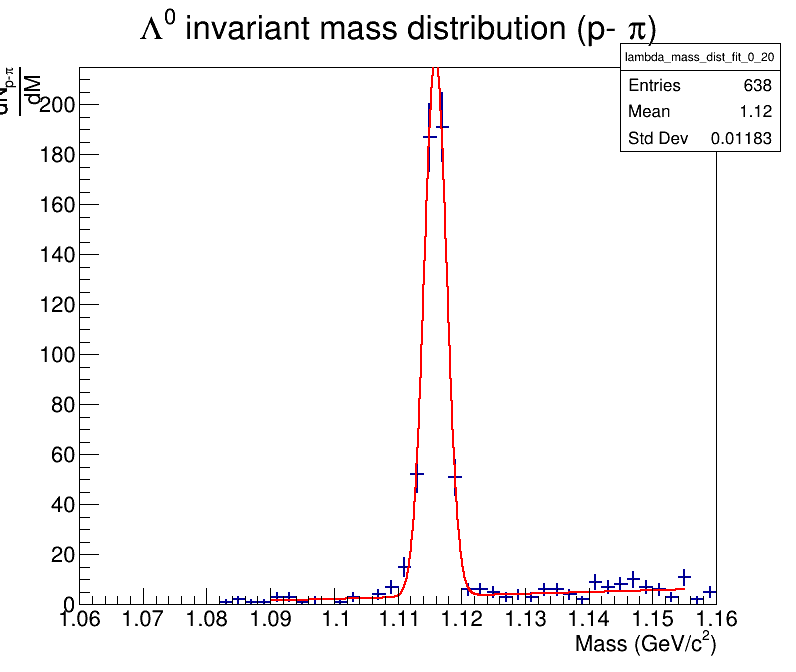

In [28]:
lambda_mass_dist_fit_0_20 = lambda_mass_dist_0_20.Clone("lambda_mass_dist_fit_0_20")
lambda_mass_dist_fit_0_20.Fit(lambda_mass_fit_0_20, "RS")
lambda_mass_dist_fit_0_20.Draw()
c.Draw()

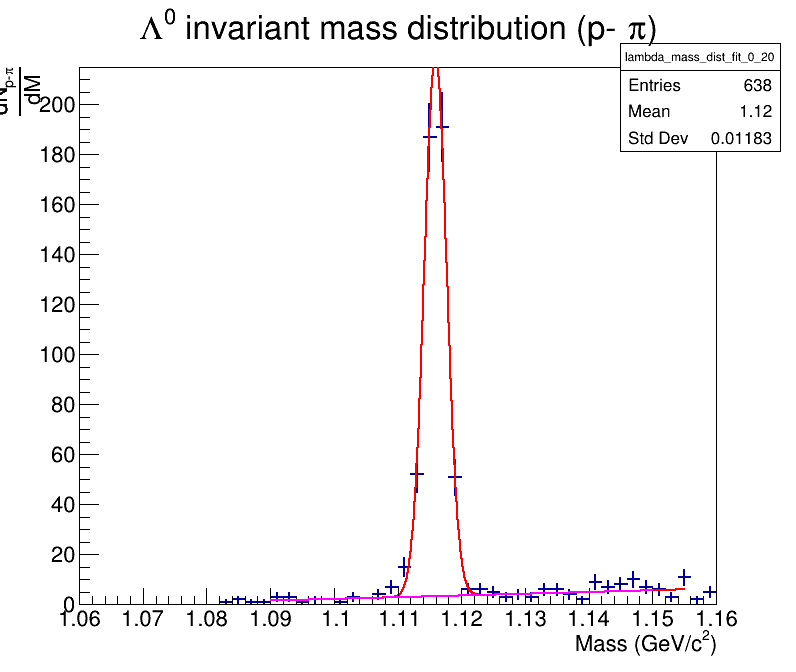

In [29]:
bg_fit_0_20 = rt.TF1("bg_fit_0_20", "pol2", 1.09, 1.15)
bg_fit_0_20.SetParameter(0, lambda_mass_fit_0_20.GetParameter(4))
bg_fit_0_20.SetParameter(1, lambda_mass_fit_0_20.GetParameter(5))
bg_fit_0_20.SetParameter(2, lambda_mass_fit_0_20.GetParameter(6))
bg_fit_0_20.SetNpx(1000)
bg_fit_0_20.SetLineColor(rt.kMagenta)
lambda_mass_dist_fit_0_20.Draw()
bg_fit_0_20.Draw("SAME")
c.Draw()

In [30]:
left_signal_bin_0_20 = lambda_mass_dist_fit_0_20.FindBin(SIG_MIN)
right_signal_bin_0_20 = lambda_mass_dist_fit_0_20.FindBin(SIG_MAX)

lambda_bg_0_20 = 0
lambda_total_0_20 = 0
for bin_num in range(left_signal_bin_0_20, right_signal_bin_0_20 + 1):
    bin_center = lambda_mass_dist_fit_0_20.GetBinCenter(bin_num)
    lambda_bg_0_20 += bg_fit_0_20.Eval(bin_center)
    lambda_total_0_20 += lambda_mass_dist_fit_0_20.GetBinContent(bin_num)

lambda_signal_0_20 = lambda_total_0_20 - lambda_bg_0_20
lambda_signal_total_ratio_0_20 = lambda_signal_0_20/lambda_total_0_20
lambda_signal_bg_ratio_0_20 = lambda_signal_0_20/lambda_bg_0_20
print(f"The 0-20 lambda signal is: {lambda_signal_0_20}")
print(f"The 0-20 lambda background is: {lambda_bg_0_20}")
print(f"The 0-20 lambda S/B is: {lambda_signal_bg_ratio_0_20}")
print(f"The 0-20 lambda S/T is: {lambda_signal_total_ratio_0_20}")
print(f"The 0-20 lambda significance is: {lambda_signal_0_20/math.sqrt(lambda_signal_0_20 + lambda_bg_0_20)}")

The 0-20 lambda signal is: 488.76829792655775
The 0-20 lambda background is: 26.231702073442236
The 0-20 lambda S/B is: 18.63273288779082
The 0-20 lambda S/T is: 0.9490646561680733
The 0-20 lambda significance is: 21.53770453454878


### Mixed event correction section

In [31]:
axes = arr.array('i', [2, 3, 4, 5])
h_lambda_0_20 = h_lambda_0_20.Projection(4, axes)
h_lambda_0_20_mc = h_lambda_0_20_mc.Projection(4, axes)
h_lambda_mixed_0_20 = h_lambda_mixed_0_20.Projection(4, axes)
h_lambda_mixed_0_20_mc = h_lambda_mixed_0_20_mc.Projection(4, axes)

In [32]:
h_h_0_20 = h_h_0_20.Projection(2, 3, 4)
h_h_0_20_mc = h_h_0_20_mc.Projection(2, 3, 4)
h_h_mixed_0_20 = h_h_mixed_0_20.Projection(2, 3, 4)
h_h_mixed_0_20_mc = h_h_mixed_0_20_mc.Projection(2, 3, 4)

In [33]:
# Setting up 2-d correlation plots before the mixed event correction
h_lambda_2d_nomixcor_0_20 = h_lambda_0_20.Projection(0, 1).Clone("h_lambda_2d_nomixcor_0_20")
h_lambda_2d_nomixcor_0_20_mc = h_lambda_0_20_mc.Projection(0, 1).Clone("h_lambda_2d_nomixcor_0_20_mc")
h_lambda_mixed_2d_0_20 = h_lambda_mixed_0_20.Projection(0, 1).Clone("h_lambda_mixed_2d_0_20")
h_lambda_mixed_2d_0_20_mc = h_lambda_mixed_0_20_mc.Projection(0, 1).Clone("h_lambda_mixed_2d_0_20_mc")

In [34]:
h_h_2d_nomixcor_0_20 = h_h_0_20_mc.Project3D("xye").Clone("h_h_2d_nomixcor_0_20")
h_h_2d_nomixcor_0_20_mc = h_h_0_20_mc.Project3D("xye").Clone("h_h_2d_nomixcor_0_20_mc")
h_h_mixed_2d_0_20 = h_h_mixed_0_20.Project3D("xye").Clone("h_h_mixed_2d_0_20")
h_h_mixed_2d_0_20_mc = h_h_mixed_0_20_mc.Project3D("xye").Clone("h_h_mixed_2d_0_20_mc")

In [35]:
h_lambda_2d_nomixcor_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_2d_nomixcor_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_nomixcor_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_0_20.GetYaxis().SetTitleOffset(1.3)

h_lambda_mixed_2d_0_20.SetTitle("Mixed-event h-#Lambda^{0} #Delta#varphi#Delta#eta")
h_lambda_mixed_2d_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_mixed_2d_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_mixed_2d_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_0_20.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_nomixcor_0_20_mc.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta (no acceptance correction, MC truth)")
h_lambda_2d_nomixcor_0_20_mc.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_0_20_mc.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_0_20_mc.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_0_20_mc.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_nomixcor_0_20_mc.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_0_20_mc.GetYaxis().SetTitleOffset(1.3)

h_lambda_mixed_2d_0_20_mc.SetTitle("Mixed-event h-#Lambda^{0} #Delta#varphi#Delta#eta (MC truth)")
h_lambda_mixed_2d_0_20_mc.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_mixed_2d_0_20_mc.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_mixed_2d_0_20_mc.GetXaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_0_20_mc.GetXaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_0_20_mc.GetYaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_0_20_mc.GetYaxis().SetTitleOffset(1.3)

In [36]:
h_h_2d_nomixcor_0_20.SetTitle("h-h #Delta#varphi#Delta#eta (no acceptance correction)")
h_h_2d_nomixcor_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_nomixcor_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_nomixcor_0_20.GetXaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_0_20.GetXaxis().SetTitleOffset(1.3)
h_h_2d_nomixcor_0_20.GetYaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_0_20.GetYaxis().SetTitleOffset(1.3)

h_h_mixed_2d_0_20.SetTitle("Mixed-event h-h #Delta#varphi#Delta#eta")
h_h_mixed_2d_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_mixed_2d_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_mixed_2d_0_20.GetXaxis().SetTitleSize(0.05)
h_h_mixed_2d_0_20.GetXaxis().SetTitleOffset(1.3)
h_h_mixed_2d_0_20.GetYaxis().SetTitleSize(0.05)
h_h_mixed_2d_0_20.GetYaxis().SetTitleOffset(1.3)

h_h_2d_nomixcor_0_20_mc.SetTitle("h-h #Delta#varphi#Delta#eta (no acceptance correction, MC truth)")
h_h_2d_nomixcor_0_20_mc.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_nomixcor_0_20_mc.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_nomixcor_0_20_mc.GetXaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_0_20_mc.GetXaxis().SetTitleOffset(1.3)
h_h_2d_nomixcor_0_20_mc.GetYaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_0_20_mc.GetYaxis().SetTitleOffset(1.3)

h_h_mixed_2d_0_20_mc.SetTitle("Mixed-event h-h #Delta#varphi#Delta#eta (MC truth)")
h_h_mixed_2d_0_20_mc.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_mixed_2d_0_20_mc.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_mixed_2d_0_20_mc.GetXaxis().SetTitleSize(0.05)
h_h_mixed_2d_0_20_mc.GetXaxis().SetTitleOffset(1.3)
h_h_mixed_2d_0_20_mc.GetYaxis().SetTitleSize(0.05)
h_h_mixed_2d_0_20_mc.GetYaxis().SetTitleOffset(1.3)

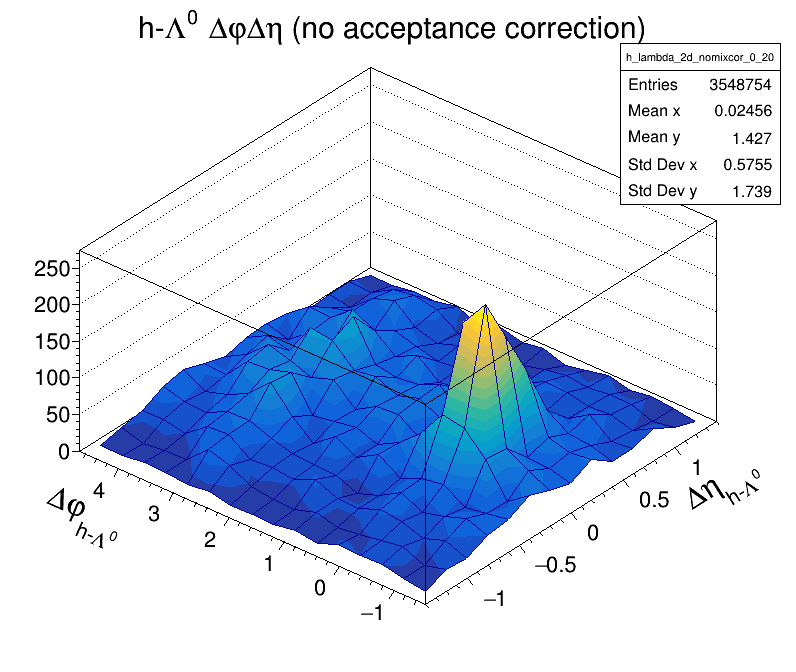

In [37]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_nomixcor_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_0_20.Draw("SURF1")
c.Draw()

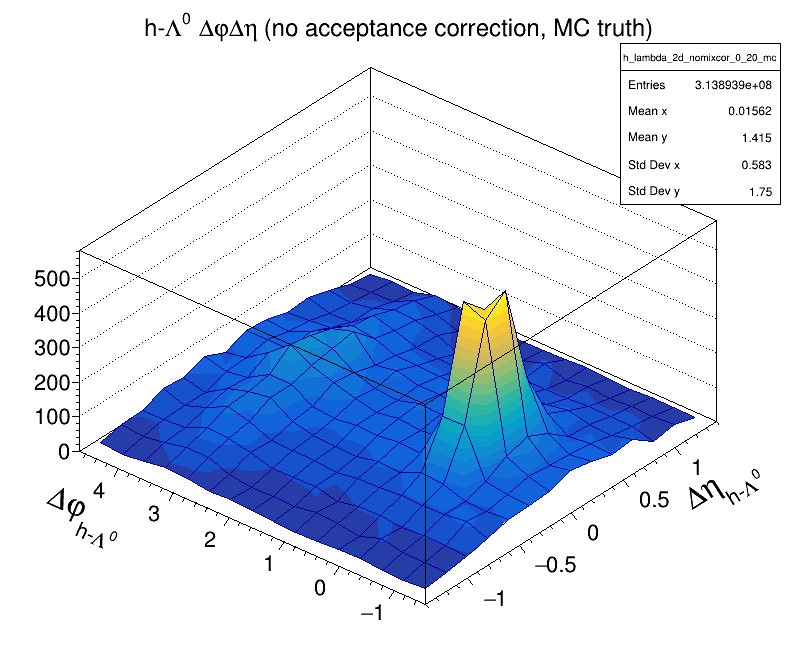

In [38]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_nomixcor_0_20_mc.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_0_20_mc.Draw("SURF1")
c.Draw()

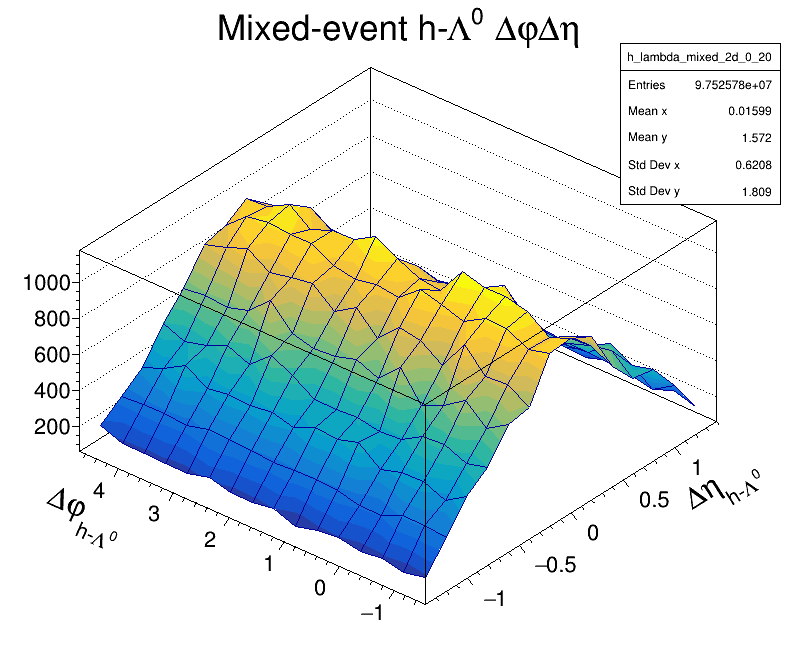

In [39]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_mixed_2d_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_mixed_2d_0_20.Draw("SURF1")
c.Draw()

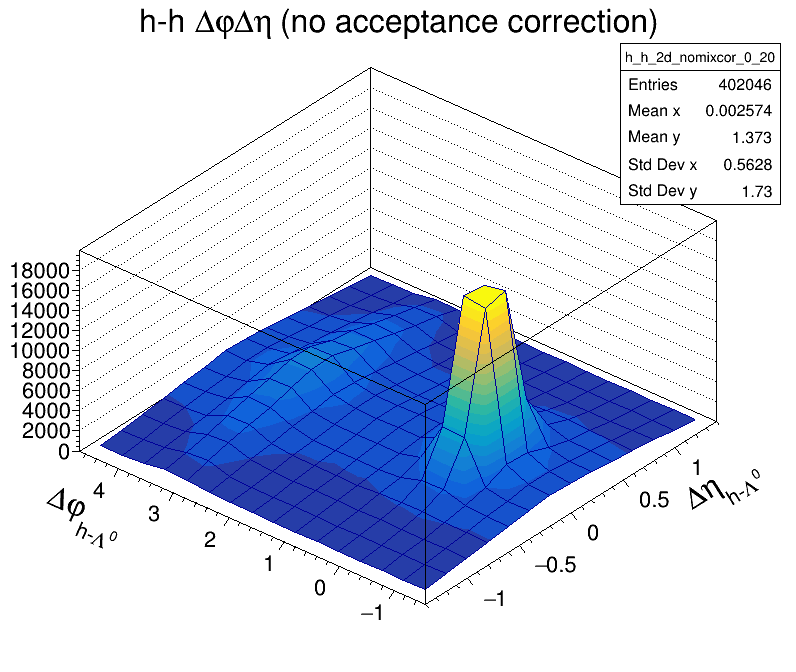

In [40]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_nomixcor_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_nomixcor_0_20.Draw("SURF1")
c.Draw()

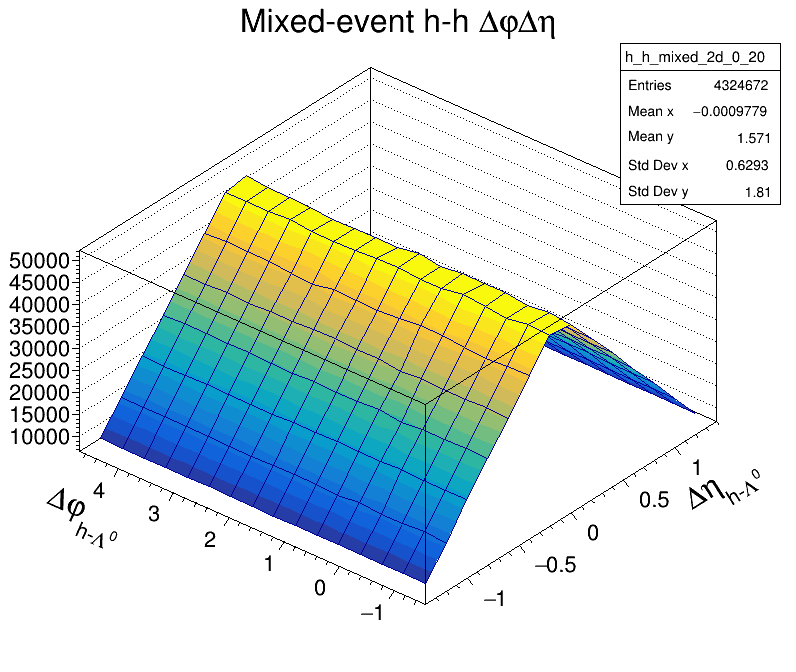

In [41]:
c.SetTheta(50)
c.SetPhi(50)
h_h_mixed_2d_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_mixed_2d_0_20.Draw("SURF1")
c.Draw()

In [42]:
h_lambda_2d_mixcor_sig_0_20 = make_mixed_corrections(h_lambda_0_20, h_lambda_mixed_0_20, SIG_MIN, SIG_MAX)

Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created


In [43]:
h_lambda_2d_mixcor_sig_0_20_mc = make_mixed_corrections(h_lambda_0_20_mc, h_lambda_mixed_0_20_mc, SIG_MIN, SIG_MAX)

Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created


In [44]:
h_h_2d_mixcor_0_20 = make_mixed_corrections(h_h_0_20, h_h_mixed_0_20, SIG_MIN, SIG_MAX, is_hh=True)
h_h_2d_mixcor_0_20_mc = make_mixed_corrections(h_h_0_20_mc, h_h_mixed_0_20_mc, SIG_MIN, SIG_MAX, is_hh=True)

Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created


In [45]:
h_lambda_2d_mixcor_sig_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (SIG, acceptance corrected)")
h_lambda_2d_mixcor_sig_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_sig_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_0_20.GetYaxis().SetTitleOffset(1.3)

In [46]:
h_h_2d_mixcor_0_20.SetTitle("h-h #Delta#varphi#Delta#eta correlation (acceptance corrected)")
h_h_2d_mixcor_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-h}")
h_h_2d_mixcor_0_20.GetXaxis().SetTitle("#Delta#eta_{h-h}")
h_h_2d_mixcor_0_20.GetXaxis().SetTitleSize(0.05)
h_h_2d_mixcor_0_20.GetXaxis().SetTitleOffset(1.3)
h_h_2d_mixcor_0_20.GetYaxis().SetTitleSize(0.05)
h_h_2d_mixcor_0_20.GetYaxis().SetTitleOffset(1.3)

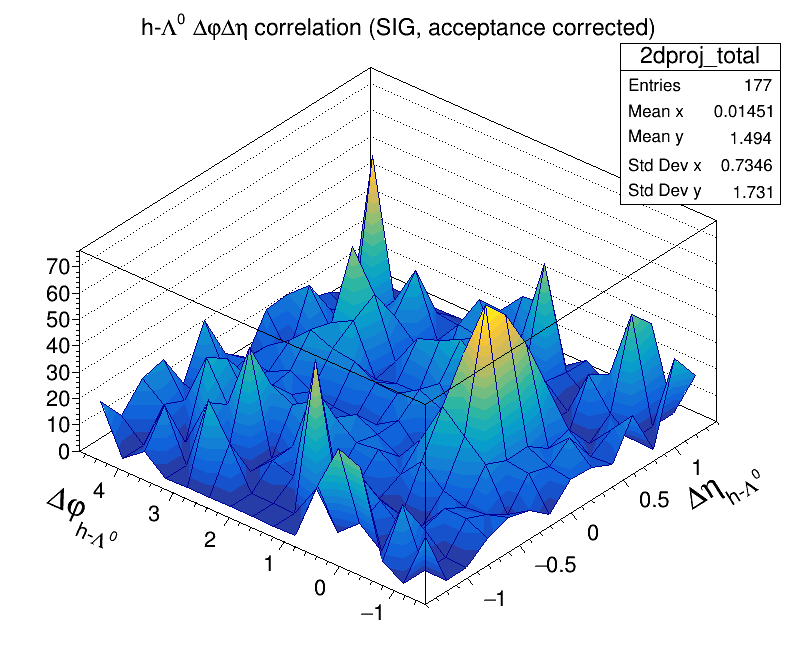

In [47]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_sig_0_20.Draw("SURF1")
c.Draw()

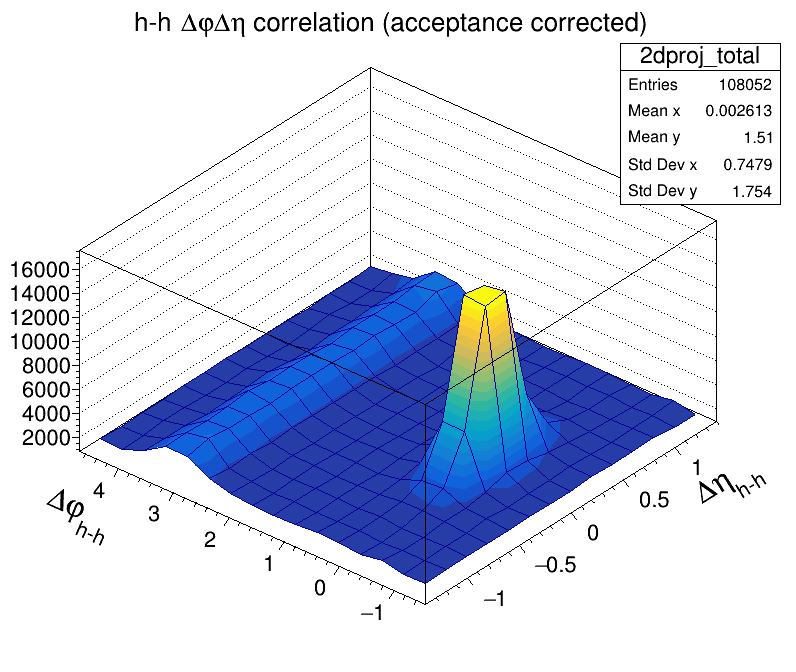

In [48]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_mixcor_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_mixcor_0_20.Draw("SURF1")
c.Draw()

In [49]:
h_lambda_2d_mixcor_sig_0_20_mc.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_mixcor_0_20_mc.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)

In [50]:
# per-trigger normalization done here
h_lambda_2d_mixcor_sig_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_2d_mixcor_sig_0_20_mc.Scale(1.0/num_trigs_0_20_mc)
h_h_2d_mixcor_0_20.Scale(1.0/num_trigs_0_20)
h_h_2d_mixcor_0_20_mc.Scale(1.0/num_trigs_0_20_mc)

In [51]:
h_lambda_2d_subtracted_0_20 = h_lambda_2d_mixcor_sig_0_20
h_lambda_2d_subtracted_0_20_mc = h_lambda_2d_mixcor_sig_0_20_mc

### Integral and ratio section

In [52]:
h_lambda_dphi_subtracted_0_20 = h_lambda_2d_subtracted_0_20.ProjectionY("h_lambda_dphi_subtracted_0_20")
h_lambda_dphi_subtracted_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (0 - 20 multiplicty bin)")
h_lambda_dphi_subtracted_0_20.SetLineColor(rt.kViolet - 6)
h_lambda_dphi_subtracted_0_20.SetLineWidth(3)
h_lambda_dphi_subtracted_0_20.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_dphi_subtracted_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_dphi_subtracted_0_20.GetXaxis().SetTitleOffset(0.5)

In [53]:
h_lambda_dphi_subtracted_0_20_mc = h_lambda_2d_subtracted_0_20_mc.ProjectionY("h_lambda_dphi_subtracted_0_20_mc")
h_lambda_dphi_subtracted_0_20_mc.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (0 - 20 multiplicty bin, MC truth)")
h_lambda_dphi_subtracted_0_20_mc.SetLineColor(rt.kViolet - 6)
h_lambda_dphi_subtracted_0_20_mc.SetLineWidth(3)
h_lambda_dphi_subtracted_0_20_mc.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_dphi_subtracted_0_20_mc.GetXaxis().SetTitleSize(0.05)
h_lambda_dphi_subtracted_0_20_mc.GetXaxis().SetTitleOffset(0.5)

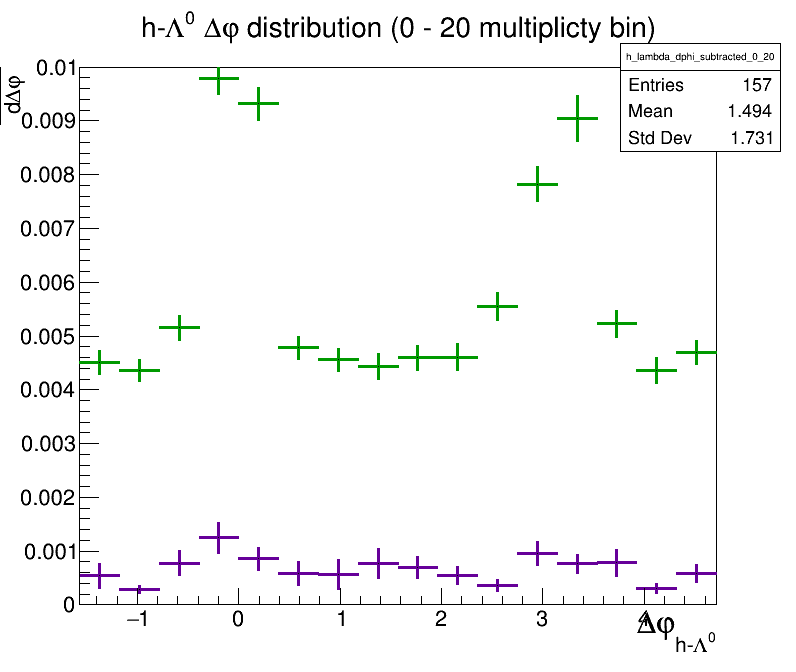

In [54]:
h_lambda_dphi_subtracted_0_20.GetYaxis().SetRangeUser(0, 0.01)
h_lambda_dphi_subtracted_0_20.Draw()
h_lambda_dphi_subtracted_0_20_mc.SetLineColor(rt.kGreen + 2)
h_lambda_dphi_subtracted_0_20_mc.Draw("SAME")
c.Draw()

In [55]:
if USE_AVG:
    ue_line_0_20 = rt.TF1("ue_line_0_20", "pol0", -2, 6)
    ue_upper_line_0_20 = rt.TF1("ue_upper_line_0_20", "pol0", -2, 6)
    ue_lower_line_0_20 = rt.TF1("ue_lower_line_0_20", "pol0", -2, 6)
    zero_line_0_20 = rt.TF1("zero_line_0_20", "pol0", -2, 6)
    zero_upper_line_0_20 = rt.TF1("zero_upper_line_0_20", "pol0", -2, 6)
    zero_lower_line_0_20 = rt.TF1("zero_lower_line_0_20", "pol0", -2, 6)
    ue_avg_0_20 = (h_lambda_dphi_subtracted_0_20.GetBinContent(1) 
                   + h_lambda_dphi_subtracted_0_20.GetBinContent(8)
                   + h_lambda_dphi_subtracted_0_20.GetBinContent(9)
                   + h_lambda_dphi_subtracted_0_20.GetBinContent(16))/4

    ue_avg_error_0_20 = (1/4)*(math.sqrt(h_lambda_dphi_subtracted_0_20.GetBinError(1)**2 
                   + h_lambda_dphi_subtracted_0_20.GetBinError(8)**2
                   + h_lambda_dphi_subtracted_0_20.GetBinError(9)**2
                   + h_lambda_dphi_subtracted_0_20.GetBinError(16)**2))


    ue_line_0_20.SetParameter(0, ue_avg_0_20)
    ue_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_line_0_20.SetLineWidth(3)
    ue_line_0_20.SetLineStyle(rt.kSolid)

    ue_upper_line_0_20.SetParameter(0, ue_avg_0_20 + ue_avg_error_0_20)
    ue_upper_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_upper_line_0_20.SetLineStyle(rt.kDashed)

    ue_lower_line_0_20.SetParameter(0, ue_avg_0_20 - ue_avg_error_0_20)
    ue_lower_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_lower_line_0_20.SetLineStyle(rt.kDashed)

    zero_line_0_20.SetParameter(0, 0)
    zero_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_line_0_20.SetLineWidth(3)
    zero_line_0_20.SetLineStyle(rt.kSolid)
    zero_upper_line_0_20.SetParameter(0, ue_avg_error_0_20)
    zero_upper_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_upper_line_0_20.SetLineStyle(rt.kDashed)
    zero_lower_line_0_20.SetParameter(0, -ue_avg_error_0_20)
    zero_lower_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_lower_line_0_20.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    ue_line_0_20 = rt.TF1("ue_line_0_20", "pol0", -2, 6)
    ue_upper_line_0_20 = rt.TF1("ue_upper_line_0_20", "pol0", -2, 6)
    ue_lower_line_0_20 = rt.TF1("ue_lower_line_0_20", "pol0", -2, 6)
    zero_line_0_20 = rt.TF1("zero_line_0_20", "pol0", -2, 6)
    zero_upper_line_0_20 = rt.TF1("zero_upper_line_0_20", "pol0", -2, 6)
    zero_lower_line_0_20 = rt.TF1("zero_lower_line_0_20", "pol0", -2, 6)
    min_bin = h_lambda_dphi_subtracted_0_20.GetMinimumBin()
    ue_avg_0_20 = h_lambda_dphi_subtracted_0_20.GetBinContent(min_bin)
    ue_avg_error_0_20 = h_lambda_dphi_subtracted_0_20.GetBinError(min_bin)


    ue_line_0_20.SetParameter(0, ue_avg_0_20)
    ue_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_line_0_20.SetLineWidth(3)
    ue_line_0_20.SetLineStyle(rt.kSolid)

    ue_upper_line_0_20.SetParameter(0, ue_avg_0_20 + ue_avg_error_0_20)
    ue_upper_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_upper_line_0_20.SetLineStyle(rt.kDashed)

    ue_lower_line_0_20.SetParameter(0, ue_avg_0_20 - ue_avg_error_0_20)
    ue_lower_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_lower_line_0_20.SetLineStyle(rt.kDashed)

    zero_line_0_20.SetParameter(0, 0)
    zero_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_line_0_20.SetLineWidth(3)
    zero_line_0_20.SetLineStyle(rt.kSolid)
    zero_upper_line_0_20.SetParameter(0, ue_avg_error_0_20)
    zero_upper_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_upper_line_0_20.SetLineStyle(rt.kDashed)
    zero_lower_line_0_20.SetParameter(0, -ue_avg_error_0_20)
    zero_lower_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_lower_line_0_20.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [56]:
if USE_AVG:
    ue_line_0_20_mc = rt.TF1("ue_line_0_20_mc", "pol0", -2, 6)
    ue_upper_line_0_20_mc = rt.TF1("ue_upper_line_0_20_mc", "pol0", -2, 6)
    ue_lower_line_0_20_mc = rt.TF1("ue_lower_line_0_20_mc", "pol0", -2, 6)
    zero_line_0_20_mc = rt.TF1("zero_line_0_20_mc", "pol0", -2, 6)
    zero_upper_line_0_20_mc = rt.TF1("zero_upper_line_0_20_mc", "pol0", -2, 6)
    zero_lower_line_0_20_mc = rt.TF1("zero_lower_line_0_20_mc", "pol0", -2, 6)
    ue_avg_0_20_mc = (h_lambda_dphi_subtracted_0_20_mc.GetBinContent(1) 
                   + h_lambda_dphi_subtracted_0_20_mc.GetBinContent(8)
                   + h_lambda_dphi_subtracted_0_20_mc.GetBinContent(9)
                   + h_lambda_dphi_subtracted_0_20_mc.GetBinContent(16))/4

    ue_avg_error_0_20_mc = (1/4)*(math.sqrt(h_lambda_dphi_subtracted_0_20_mc.GetBinError(1)**2 
                   + h_lambda_dphi_subtracted_0_20_mc.GetBinError(8)**2
                   + h_lambda_dphi_subtracted_0_20_mc.GetBinError(9)**2
                   + h_lambda_dphi_subtracted_0_20_mc.GetBinError(16)**2))


    ue_line_0_20_mc.SetParameter(0, ue_avg_0_20_mc)
    ue_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    ue_line_0_20_mc.SetLineWidth(3)
    ue_line_0_20_mc.SetLineStyle(rt.kSolid)

    ue_upper_line_0_20_mc.SetParameter(0, ue_avg_0_20_mc + ue_avg_error_0_20_mc)
    ue_upper_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    ue_upper_line_0_20_mc.SetLineStyle(rt.kDashed)

    ue_lower_line_0_20_mc.SetParameter(0, ue_avg_0_20_mc - ue_avg_error_0_20_mc)
    ue_lower_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    ue_lower_line_0_20_mc.SetLineStyle(rt.kDashed)

    zero_line_0_20_mc.SetParameter(0, 0)
    zero_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    zero_line_0_20_mc.SetLineWidth(3)
    zero_line_0_20_mc.SetLineStyle(rt.kSolid)
    zero_upper_line_0_20_mc.SetParameter(0, ue_avg_error_0_20_mc)
    zero_upper_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    zero_upper_line_0_20_mc.SetLineStyle(rt.kDashed)
    zero_lower_line_0_20_mc.SetParameter(0, -ue_avg_error_0_20_mc)
    zero_lower_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    zero_lower_line_0_20_mc.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    ue_line_0_20_mc = rt.TF1("ue_line_0_20_mc", "pol0", -2, 6)
    ue_upper_line_0_20_mc = rt.TF1("ue_upper_line_0_20_mc", "pol0", -2, 6)
    ue_lower_line_0_20_mc = rt.TF1("ue_lower_line_0_20_mc", "pol0", -2, 6)
    zero_line_0_20_mc = rt.TF1("zero_line_0_20_mc", "pol0", -2, 6)
    zero_upper_line_0_20_mc = rt.TF1("zero_upper_line_0_20_mc", "pol0", -2, 6)
    zero_lower_line_0_20_mc = rt.TF1("zero_lower_line_0_20_mc", "pol0", -2, 6)
    min_bin = h_lambda_dphi_subtracted_0_20_mc.GetMinimumBin()
    ue_avg_0_20_mc = h_lambda_dphi_subtracted_0_20_mc.GetBinContent(min_bin)
    ue_avg_error_0_20_mc = h_lambda_dphi_subtracted_0_20_mc.GetBinError(min_bin)


    ue_line_0_20_mc.SetParameter(0, ue_avg_0_20_mc)
    ue_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    ue_line_0_20_mc.SetLineWidth(3)
    ue_line_0_20_mc.SetLineStyle(rt.kSolid)

    ue_upper_line_0_20_mc.SetParameter(0, ue_avg_0_20_mc + ue_avg_error_0_20_mc)
    ue_upper_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    ue_upper_line_0_20_mc.SetLineStyle(rt.kDashed)

    ue_lower_line_0_20_mc.SetParameter(0, ue_avg_0_20_mc - ue_avg_error_0_20_mc)
    ue_lower_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    ue_lower_line_0_20_mc.SetLineStyle(rt.kDashed)

    zero_line_0_20_mc.SetParameter(0, 0)
    zero_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    zero_line_0_20_mc.SetLineWidth(3)
    zero_line_0_20_mc.SetLineStyle(rt.kSolid)
    zero_upper_line_0_20_mc.SetParameter(0, ue_avg_error_0_20_mc)
    zero_upper_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    zero_upper_line_0_20_mc.SetLineStyle(rt.kDashed)
    zero_lower_line_0_20_mc.SetParameter(0, -ue_avg_error_0_20_mc)
    zero_lower_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    zero_lower_line_0_20_mc.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

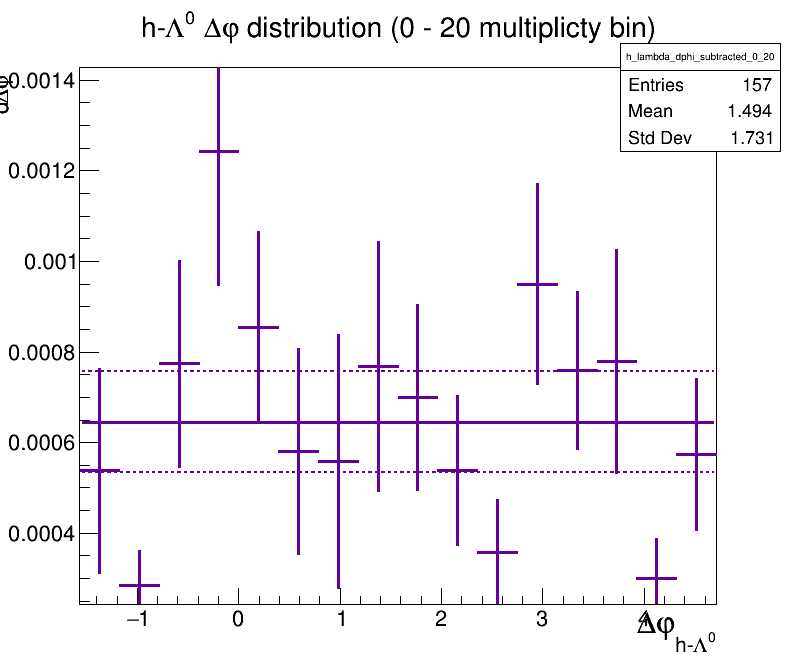

In [57]:
min_bin = h_lambda_dphi_subtracted_0_20.GetMinimumBin()
min_val = h_lambda_dphi_subtracted_0_20.GetBinContent(min_bin)
max_bin = h_lambda_dphi_subtracted_0_20.GetMaximumBin()
max_val = h_lambda_dphi_subtracted_0_20.GetBinContent(max_bin)

h_lambda_dphi_subtracted_0_20.GetYaxis().SetRangeUser(0.85*min_val, 1.15*max_val)
h_lambda_dphi_subtracted_0_20.Draw()
ue_line_0_20.Draw("SAME")
ue_upper_line_0_20.Draw("SAME")
ue_lower_line_0_20.Draw("SAME")
c.Draw()

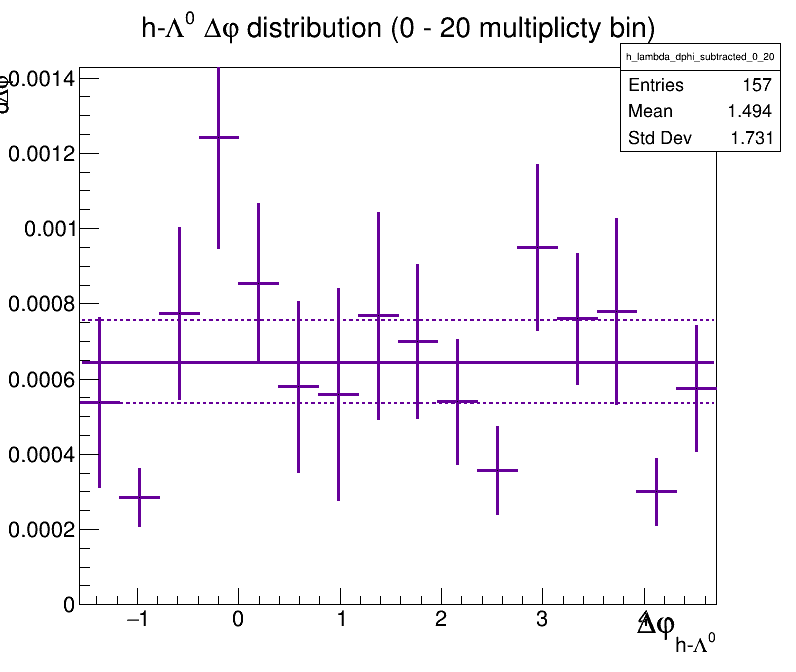

In [58]:
h_lambda_dphi_subtracted_0_20.GetYaxis().SetRangeUser(0, 1.15*max_val)
h_lambda_dphi_subtracted_0_20.Draw()
ue_line_0_20.Draw("SAME")
ue_upper_line_0_20.Draw("SAME")
ue_lower_line_0_20.Draw("SAME")
c.Draw()

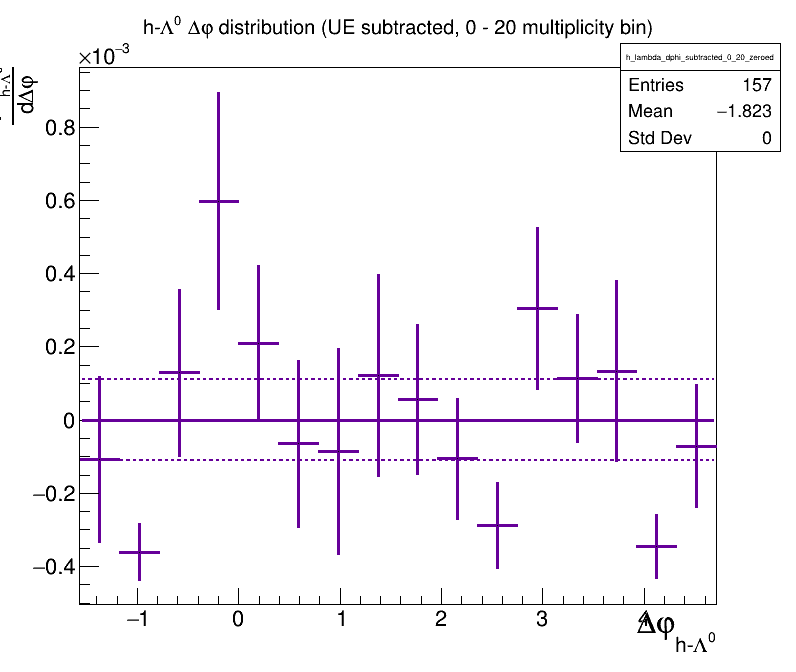

In [59]:
h_lambda_dphi_subtracted_0_20_zeroed = h_lambda_dphi_subtracted_0_20.Clone("h_lambda_dphi_subtracted_0_20_zeroed")
h_lambda_dphi_subtracted_0_20_zeroed.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (UE subtracted, 0 - 20 multiplicity bin)")
h_lambda_dphi_subtracted_0_20_zeroed.Add(ue_line_0_20, -1)
h_lambda_dphi_subtracted_0_20_zeroed.Draw()
zero_line_0_20.Draw("SAME")
zero_upper_line_0_20.Draw("SAME")
zero_lower_line_0_20.Draw("SAME")
c.Draw()

In [60]:
DPHI_BINS = h_lambda_dphi_subtracted_0_20.GetNbinsX()

In [61]:
h_lambda_total_integral_0_20 = 0
h_lambda_near_integral_0_20 = 0
h_lambda_away_integral_0_20 = 0
h_lambda_ue_integral_0_20 = ue_avg_0_20*DPHI_BINS

h_lambda_total_integral_error_0_20 = 0
h_lambda_near_integral_error_0_20 = 0
h_lambda_away_integral_error_0_20 = 0
h_lambda_ue_integral_error_0_20 = ue_avg_error_0_20*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_lambda_total_integral_0_20 += h_lambda_dphi_subtracted_0_20.GetBinContent(bin_num)
    h_lambda_total_integral_error_0_20 += h_lambda_dphi_subtracted_0_20.GetBinError(bin_num)**2
    part = h_lambda_dphi_subtracted_0_20.GetBinContent(bin_num) - ue_avg_0_20
    if part < 0:
        continue
    if bin_num < 9:
        h_lambda_near_integral_0_20 += part
        h_lambda_near_integral_error_0_20 += h_lambda_dphi_subtracted_0_20.GetBinError(bin_num)**2
        h_lambda_near_integral_error_0_20 += ue_avg_error_0_20**2
    else:
        h_lambda_away_integral_0_20 += part
        h_lambda_away_integral_error_0_20 += h_lambda_dphi_subtracted_0_20.GetBinError(bin_num)**2
        h_lambda_away_integral_error_0_20 += ue_avg_error_0_20**2
h_lambda_total_integral_error_0_20 = math.sqrt(h_lambda_total_integral_error_0_20)
h_lambda_near_integral_error_0_20 = math.sqrt(h_lambda_near_integral_error_0_20)
h_lambda_away_integral_error_0_20 = math.sqrt(h_lambda_away_integral_error_0_20)

In [62]:
h_lambda_total_integral_0_20_mc = 0
h_lambda_near_integral_0_20_mc = 0
h_lambda_away_integral_0_20_mc = 0
h_lambda_ue_integral_0_20_mc = ue_avg_0_20_mc*DPHI_BINS

h_lambda_total_integral_error_0_20_mc = 0
h_lambda_near_integral_error_0_20_mc = 0
h_lambda_away_integral_error_0_20_mc = 0
h_lambda_ue_integral_error_0_20_mc = ue_avg_error_0_20_mc*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_lambda_total_integral_0_20_mc += h_lambda_dphi_subtracted_0_20_mc.GetBinContent(bin_num)
    h_lambda_total_integral_error_0_20_mc += h_lambda_dphi_subtracted_0_20_mc.GetBinError(bin_num)**2
    part = h_lambda_dphi_subtracted_0_20_mc.GetBinContent(bin_num) - ue_avg_0_20_mc
    if part < 0:
        continue
    if bin_num < 9:
        h_lambda_near_integral_0_20_mc += part 
        h_lambda_near_integral_error_0_20_mc += h_lambda_dphi_subtracted_0_20_mc.GetBinError(bin_num)**2
        h_lambda_near_integral_error_0_20_mc += ue_avg_error_0_20_mc**2
    else:
        h_lambda_away_integral_0_20_mc += part 
        h_lambda_away_integral_error_0_20_mc += h_lambda_dphi_subtracted_0_20_mc.GetBinError(bin_num)**2
        h_lambda_away_integral_error_0_20_mc += ue_avg_error_0_20_mc**2
h_lambda_total_integral_error_0_20_mc = math.sqrt(h_lambda_total_integral_error_0_20_mc)
h_lambda_near_integral_error_0_20_mc = math.sqrt(h_lambda_near_integral_error_0_20_mc)
h_lambda_away_integral_error_0_20_mc = math.sqrt(h_lambda_away_integral_error_0_20_mc)

In [63]:
h_h_dphi_0_20 = h_h_2d_mixcor_0_20.ProjectionY("h_h_dphi_0_20")
h_h_dphi_0_20.SetTitle("h-h #Delta#varphi distribution (0 - 20 multiplicty bin)")
h_h_dphi_0_20.SetLineColor(rt.kRed)
h_h_dphi_0_20.SetLineWidth(3)
h_h_dphi_0_20.GetYaxis().SetTitle("#frac{dN_{h-h}}{d#Delta#varphi}")
h_h_dphi_0_20.GetXaxis().SetTitleSize(0.05)
h_h_dphi_0_20.GetXaxis().SetTitleOffset(0.5)

In [64]:
h_h_dphi_0_20_mc = h_h_2d_mixcor_0_20_mc.ProjectionY("h_h_dphi_0_20_mc")
h_h_dphi_0_20_mc.SetTitle("h-h #Delta#varphi distribution (0 - 20 multiplicty bin)")
h_h_dphi_0_20_mc.SetLineColor(rt.kBlue)
h_h_dphi_0_20_mc.SetLineWidth(3)
h_h_dphi_0_20_mc.GetYaxis().SetTitle("#frac{dN_{h-h}}{d#Delta#varphi}")
h_h_dphi_0_20_mc.GetXaxis().SetTitleSize(0.05)
h_h_dphi_0_20_mc.GetXaxis().SetTitleOffset(0.5)

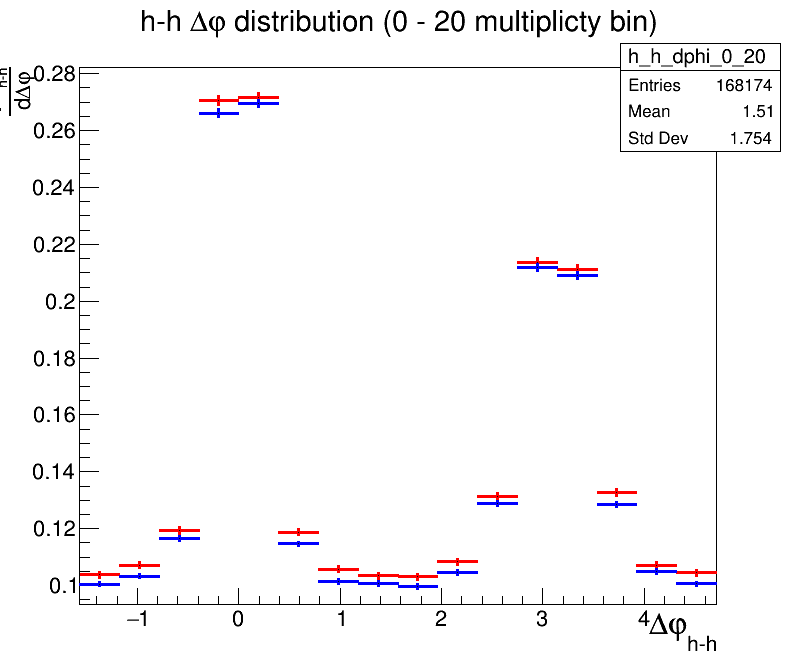

In [65]:
h_h_dphi_0_20.Draw()
h_h_dphi_0_20_mc.Draw("SAME")

c.Draw()

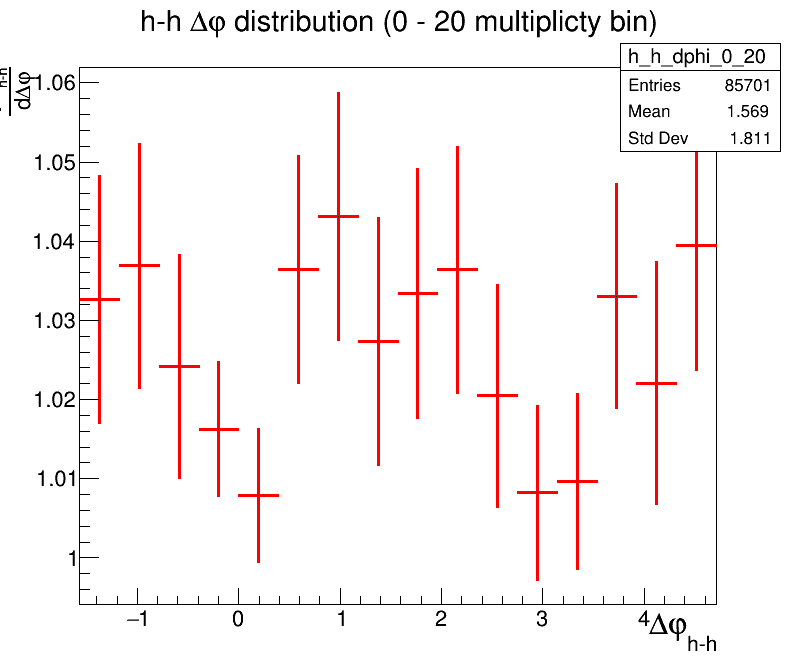

In [66]:
h_h_dphi_0_20.Divide(h_h_dphi_0_20_mc)
h_h_dphi_0_20.Draw()

c.Draw()

In [67]:
if USE_AVG:
    hh_ue_line_0_20 = rt.TF1("hh_ue_line_0_20", "pol0", -2, 6)
    hh_ue_upper_line_0_20 = rt.TF1("hh_ue_upper_line_0_20", "pol0", -2, 6)
    hh_ue_lower_line_0_20 = rt.TF1("hh_ue_lower_line_0_20", "pol0", -2, 6)
    hh_zero_line_0_20 = rt.TF1("hh_zero_line_0_20", "pol0", -2, 6)
    hh_zero_upper_line_0_20 = rt.TF1("hh_zero_upper_line_0_20", "pol0", -2, 6)
    hh_zero_lower_line_0_20 = rt.TF1("hh_zero_lower_line_0_20", "pol0", -2, 6)
    hh_ue_avg_0_20 = (h_h_dphi_0_20.GetBinContent(1) 
                   + h_h_dphi_0_20.GetBinContent(8)
                   + h_h_dphi_0_20.GetBinContent(9)
                   + h_h_dphi_0_20.GetBinContent(16))/4

    hh_ue_avg_error_0_20 = (1/4)*(math.sqrt(h_h_dphi_0_20.GetBinError(1)**2 
                   + h_h_dphi_0_20.GetBinError(8)**2
                   + h_h_dphi_0_20.GetBinError(9)**2
                   + h_h_dphi_0_20.GetBinError(16)**2))


    hh_ue_line_0_20.SetParameter(0, hh_ue_avg_0_20)
    hh_ue_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_line_0_20.SetLineWidth(3)
    hh_ue_line_0_20.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_0_20.SetParameter(0, hh_ue_avg_0_20 + hh_ue_avg_error_0_20)
    hh_ue_upper_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_upper_line_0_20.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_0_20.SetParameter(0, hh_ue_avg_0_20 - hh_ue_avg_error_0_20)
    hh_ue_lower_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_lower_line_0_20.SetLineStyle(rt.kDashed)

    hh_zero_line_0_20.SetParameter(0, 0)
    hh_zero_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_line_0_20.SetLineWidth(3)
    hh_zero_line_0_20.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_0_20.SetParameter(0, hh_ue_avg_error_0_20)
    hh_zero_upper_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_upper_line_0_20.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_0_20.SetParameter(0, -hh_ue_avg_error_0_20)
    hh_zero_lower_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_lower_line_0_20.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    hh_ue_line_0_20 = rt.TF1("hh_ue_line_0_20", "pol0", -2, 6)
    hh_ue_upper_line_0_20 = rt.TF1("hh_ue_upper_line_0_20", "pol0", -2, 6)
    hh_ue_lower_line_0_20 = rt.TF1("hh_ue_lower_line_0_20", "pol0", -2, 6)
    hh_zero_line_0_20 = rt.TF1("hh_zero_line_0_20", "pol0", -2, 6)
    hh_zero_upper_line_0_20 = rt.TF1("hh_zero_upper_line_0_20", "pol0", -2, 6)
    hh_zero_lower_line_0_20 = rt.TF1("hh_zero_lower_line_0_20", "pol0", -2, 6)
    
    min_bin = h_h_dphi_0_20.GetMinimumBin()
    hh_ue_avg_0_20 = h_h_dphi_0_20.GetBinContent(min_bin)
    hh_ue_avg_error_0_20 = h_h_dphi_0_20.GetBinError(min_bin)

    hh_ue_line_0_20.SetParameter(0, hh_ue_avg_0_20)
    hh_ue_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_line_0_20.SetLineWidth(3)
    hh_ue_line_0_20.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_0_20.SetParameter(0, hh_ue_avg_0_20 + hh_ue_avg_error_0_20)
    hh_ue_upper_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_upper_line_0_20.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_0_20.SetParameter(0, hh_ue_avg_0_20 - hh_ue_avg_error_0_20)
    hh_ue_lower_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_lower_line_0_20.SetLineStyle(rt.kDashed)

    hh_zero_line_0_20.SetParameter(0, 0)
    hh_zero_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_line_0_20.SetLineWidth(3)
    hh_zero_line_0_20.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_0_20.SetParameter(0, hh_ue_avg_error_0_20)
    hh_zero_upper_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_upper_line_0_20.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_0_20.SetParameter(0, -hh_ue_avg_error_0_20)
    hh_zero_lower_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_lower_line_0_20.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
if USE_AVG:
    hh_ue_line_0_20_mc = rt.TF1("hh_ue_line_0_20_mc", "pol0", -2, 6)
    hh_ue_upper_line_0_20_mc = rt.TF1("hh_ue_upper_line_0_20_mc", "pol0", -2, 6)
    hh_ue_lower_line_0_20_mc = rt.TF1("hh_ue_lower_line_0_20_mc", "pol0", -2, 6)
    hh_zero_line_0_20_mc = rt.TF1("hh_zero_line_0_20_mc", "pol0", -2, 6)
    hh_zero_upper_line_0_20_mc = rt.TF1("hh_zero_upper_line_0_20_mc", "pol0", -2, 6)
    hh_zero_lower_line_0_20_mc = rt.TF1("hh_zero_lower_line_0_20_mc", "pol0", -2, 6)
    hh_ue_avg_0_20_mc = (h_h_dphi_0_20_mc.GetBinContent(1) 
                   + h_h_dphi_0_20_mc.GetBinContent(8)
                   + h_h_dphi_0_20_mc.GetBinContent(9)
                   + h_h_dphi_0_20_mc.GetBinContent(16))/4

    hh_ue_avg_error_0_20_mc = (1/4)*(math.sqrt(h_h_dphi_0_20_mc.GetBinError(1)**2 
                   + h_h_dphi_0_20_mc.GetBinError(8)**2
                   + h_h_dphi_0_20_mc.GetBinError(9)**2
                   + h_h_dphi_0_20_mc.GetBinError(16)**2))


    hh_ue_line_0_20_mc.SetParameter(0, hh_ue_avg_0_20_mc)
    hh_ue_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_ue_line_0_20_mc.SetLineWidth(3)
    hh_ue_line_0_20_mc.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_0_20_mc.SetParameter(0, hh_ue_avg_0_20_mc + hh_ue_avg_error_0_20_mc)
    hh_ue_upper_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_ue_upper_line_0_20_mc.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_0_20_mc.SetParameter(0, hh_ue_avg_0_20_mc - hh_ue_avg_error_0_20_mc)
    hh_ue_lower_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_ue_lower_line_0_20_mc.SetLineStyle(rt.kDashed)

    hh_zero_line_0_20_mc.SetParameter(0, 0)
    hh_zero_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_zero_line_0_20_mc.SetLineWidth(3)
    hh_zero_line_0_20_mc.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_0_20_mc.SetParameter(0, hh_ue_avg_error_0_20_mc)
    hh_zero_upper_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_zero_upper_line_0_20_mc.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_0_20_mc.SetParameter(0, -hh_ue_avg_error_0_20_mc)
    hh_zero_lower_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_zero_lower_line_0_20_mc.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    hh_ue_line_0_20_mc = rt.TF1("hh_ue_line_0_20_mc", "pol0", -2, 6)
    hh_ue_upper_line_0_20_mc = rt.TF1("hh_ue_upper_line_0_20_mc", "pol0", -2, 6)
    hh_ue_lower_line_0_20_mc = rt.TF1("hh_ue_lower_line_0_20_mc", "pol0", -2, 6)
    hh_zero_line_0_20_mc = rt.TF1("hh_zero_line_0_20_mc", "pol0", -2, 6)
    hh_zero_upper_line_0_20_mc = rt.TF1("hh_zero_upper_line_0_20_mc", "pol0", -2, 6)
    hh_zero_lower_line_0_20_mc = rt.TF1("hh_zero_lower_line_0_20_mc", "pol0", -2, 6)
    
    min_bin = h_h_dphi_0_20_mc.GetMinimumBin()
    hh_ue_avg_0_20_mc = h_h_dphi_0_20_mc.GetBinContent(min_bin)
    hh_ue_avg_error_0_20_mc = h_h_dphi_0_20_mc.GetBinError(min_bin)

    hh_ue_line_0_20_mc.SetParameter(0, hh_ue_avg_0_20_mc)
    hh_ue_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_ue_line_0_20_mc.SetLineWidth(3)
    hh_ue_line_0_20_mc.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_0_20_mc.SetParameter(0, hh_ue_avg_0_20_mc + hh_ue_avg_error_0_20_mc)
    hh_ue_upper_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_ue_upper_line_0_20_mc.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_0_20_mc.SetParameter(0, hh_ue_avg_0_20_mc - hh_ue_avg_error_0_20_mc)
    hh_ue_lower_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_ue_lower_line_0_20_mc.SetLineStyle(rt.kDashed)

    hh_zero_line_0_20_mc.SetParameter(0, 0)
    hh_zero_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_zero_line_0_20_mc.SetLineWidth(3)
    hh_zero_line_0_20_mc.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_0_20_mc.SetParameter(0, hh_ue_avg_error_0_20_mc)
    hh_zero_upper_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_zero_upper_line_0_20_mc.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_0_20_mc.SetParameter(0, -hh_ue_avg_error_0_20_mc)
    hh_zero_lower_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_zero_lower_line_0_20_mc.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
min_bin = h_h_dphi_0_20.GetMinimumBin()
min_val = h_h_dphi_0_20.GetBinContent(min_bin)
max_bin = h_h_dphi_0_20.GetMaximumBin()
max_val = h_h_dphi_0_20.GetBinContent(max_bin)

h_h_dphi_0_20.GetYaxis().SetRangeUser(0.85*min_val, 1.15*max_val)

h_h_dphi_0_20.Draw()
hh_ue_line_0_20.Draw("SAME")
hh_ue_upper_line_0_20.Draw("SAME")
hh_ue_lower_line_0_20.Draw("SAME")
c.Draw()

In [ ]:
h_h_dphi_0_20.GetYaxis().SetRangeUser(0, h_h_dphi_0_20.GetMaximum()*1.1)
h_h_dphi_0_20.Draw()
hh_ue_line_0_20.Draw("SAME")
hh_ue_upper_line_0_20.Draw("SAME")
hh_ue_lower_line_0_20.Draw("SAME")
c.Draw()

In [ ]:
h_h_dphi_0_20_zeroed = h_h_dphi_0_20.Clone("h_h_dphi_0_20_zeroed")
h_h_dphi_0_20_zeroed.SetTitle("h-h #Delta#varphi distribution (UE subtracted, 0 - 20 multiplicity bin)")
h_h_dphi_0_20_zeroed.Add(hh_ue_line_0_20, -1)
h_h_dphi_0_20_zeroed.Draw()
hh_zero_line_0_20.Draw("SAME")
hh_zero_upper_line_0_20.Draw("SAME")
hh_zero_lower_line_0_20.Draw("SAME")
c.Draw()

In [ ]:
h_h_total_integral_0_20 = 0
h_h_near_integral_0_20 = 0
h_h_away_integral_0_20 = 0
h_h_ue_integral_0_20 = hh_ue_avg_0_20*DPHI_BINS

h_h_total_integral_error_0_20 = 0
h_h_near_integral_error_0_20 = 0
h_h_away_integral_error_0_20 = 0
h_h_ue_integral_error_0_20 = hh_ue_avg_error_0_20*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_h_total_integral_0_20 += h_h_dphi_0_20.GetBinContent(bin_num)
    h_h_total_integral_error_0_20 += h_h_dphi_0_20.GetBinError(bin_num)**2
    part = h_h_dphi_0_20.GetBinContent(bin_num) - hh_ue_avg_0_20
    if part < 0:
        continue
    if bin_num < 9:
        h_h_near_integral_0_20 += part
        h_h_near_integral_error_0_20 += h_h_dphi_0_20.GetBinError(bin_num)**2
        h_h_near_integral_error_0_20 += hh_ue_avg_error_0_20**2
    else:
        h_h_away_integral_0_20 += part
        h_h_away_integral_error_0_20 += h_h_dphi_0_20.GetBinError(bin_num)**2
        h_h_away_integral_error_0_20 += hh_ue_avg_error_0_20**2
h_h_total_integral_error_0_20 = math.sqrt(h_h_total_integral_error_0_20)
h_h_near_integral_error_0_20 = math.sqrt(h_h_near_integral_error_0_20)
h_h_away_integral_error_0_20 = math.sqrt(h_h_away_integral_error_0_20)

In [ ]:
h_h_total_integral_0_20_mc = 0
h_h_near_integral_0_20_mc = 0
h_h_away_integral_0_20_mc = 0
h_h_ue_integral_0_20_mc = hh_ue_avg_0_20_mc*DPHI_BINS

h_h_total_integral_error_0_20_mc = 0
h_h_near_integral_error_0_20_mc = 0
h_h_away_integral_error_0_20_mc = 0
h_h_ue_integral_error_0_20_mc = hh_ue_avg_error_0_20_mc*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_h_total_integral_0_20_mc += h_h_dphi_0_20_mc.GetBinContent(bin_num)
    h_h_total_integral_error_0_20_mc += h_h_dphi_0_20_mc.GetBinError(bin_num)**2
    part = h_h_dphi_0_20_mc.GetBinContent(bin_num) - hh_ue_avg_0_20_mc
    if part < 0:
        continue
    if bin_num < 9:
        h_h_near_integral_0_20_mc += part
        h_h_near_integral_error_0_20_mc += h_h_dphi_0_20_mc.GetBinError(bin_num)**2
        h_h_near_integral_error_0_20_mc += hh_ue_avg_error_0_20_mc**2
    else:
        h_h_away_integral_0_20_mc += part
        h_h_away_integral_error_0_20_mc += h_h_dphi_0_20_mc.GetBinError(bin_num)**2
        h_h_away_integral_error_0_20_mc += hh_ue_avg_error_0_20_mc**2
h_h_total_integral_error_0_20_mc = math.sqrt(h_h_total_integral_error_0_20_mc)
h_h_near_integral_error_0_20_mc = math.sqrt(h_h_near_integral_error_0_20_mc)
h_h_away_integral_error_0_20_mc = math.sqrt(h_h_away_integral_error_0_20_mc)

In [ ]:
near_ratio_0_20 = h_lambda_near_integral_0_20/h_h_near_integral_0_20
away_ratio_0_20 = h_lambda_away_integral_0_20/h_h_away_integral_0_20
ue_ratio_0_20 = h_lambda_ue_integral_0_20/h_h_ue_integral_0_20
total_ratio_0_20 = h_lambda_total_integral_0_20/h_h_total_integral_0_20

near_ratio_error_0_20 = near_ratio_0_20*math.sqrt((h_lambda_near_integral_error_0_20/h_lambda_near_integral_0_20)**2
                                                 + (h_h_near_integral_error_0_20/h_h_near_integral_0_20)**2)
away_ratio_error_0_20 = away_ratio_0_20*math.sqrt((h_lambda_away_integral_error_0_20/h_lambda_away_integral_0_20)**2
                                                 + (h_h_away_integral_error_0_20/h_h_away_integral_0_20)**2)
ue_ratio_error_0_20 = ue_ratio_0_20*math.sqrt((h_lambda_ue_integral_error_0_20/h_lambda_ue_integral_0_20)**2
                                                 + (h_h_ue_integral_error_0_20/h_h_ue_integral_0_20)**2)
total_ratio_error_0_20 = total_ratio_0_20*math.sqrt((h_lambda_total_integral_error_0_20/h_lambda_total_integral_0_20)**2
                                                 + (h_h_total_integral_error_0_20/h_h_total_integral_0_20)**2)

In [ ]:
near_ratio_0_20_mc = h_lambda_near_integral_0_20_mc/h_h_near_integral_0_20_mc
away_ratio_0_20_mc = h_lambda_away_integral_0_20_mc/h_h_away_integral_0_20_mc
ue_ratio_0_20_mc = h_lambda_ue_integral_0_20_mc/h_h_ue_integral_0_20_mc
total_ratio_0_20_mc = h_lambda_total_integral_0_20_mc/h_h_total_integral_0_20_mc

near_ratio_error_0_20_mc = near_ratio_0_20_mc*math.sqrt((h_lambda_near_integral_error_0_20_mc/h_lambda_near_integral_0_20_mc)**2
                                                 + (h_h_near_integral_error_0_20_mc/h_h_near_integral_0_20_mc)**2)
away_ratio_error_0_20_mc = away_ratio_0_20_mc*math.sqrt((h_lambda_away_integral_error_0_20_mc/h_lambda_away_integral_0_20_mc)**2
                                                 + (h_h_away_integral_error_0_20_mc/h_h_away_integral_0_20_mc)**2)
ue_ratio_error_0_20_mc = ue_ratio_0_20_mc*math.sqrt((h_lambda_ue_integral_error_0_20_mc/h_lambda_ue_integral_0_20_mc)**2
                                                 + (h_h_ue_integral_error_0_20_mc/h_h_ue_integral_0_20_mc)**2)
total_ratio_error_0_20_mc = total_ratio_0_20_mc*math.sqrt((h_lambda_total_integral_error_0_20_mc/h_lambda_total_integral_0_20_mc)**2
                                                 + (h_h_total_integral_error_0_20_mc/h_h_total_integral_0_20_mc)**2)